# **Set up PySpark in Colab**

In [1]:
# Spark is written in the Scala programming language and requires the Java Virtual Machine (JVM) to run. Therefore, we download Java.
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [2]:
# Download Apache Spark. You can find the link to the file at https://spark.apache.org/downloads.html 
!wget https://dlcdn.apache.org/spark/spark-3.2.0/spark-3.2.0-bin-hadoop3.2.tgz

--2021-12-17 04:06:36--  https://dlcdn.apache.org/spark/spark-3.2.0/spark-3.2.0-bin-hadoop3.2.tgz
Resolving dlcdn.apache.org (dlcdn.apache.org)... 151.101.2.132, 2a04:4e42::644
Connecting to dlcdn.apache.org (dlcdn.apache.org)|151.101.2.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 300965906 (287M) [application/x-gzip]
Saving to: ‘spark-3.2.0-bin-hadoop3.2.tgz’

spark-3.2.0-bin-had 100%[===================>] 287.02M   149MB/s    in 1.9s    

2021-12-17 04:06:38 (149 MB/s) - ‘spark-3.2.0-bin-hadoop3.2.tgz’ saved [300965906/300965906]



In [3]:
# Unzip Apache Spark with Hadoop 3.2
!tar xvzf spark-3.2.0-bin-hadoop3.2.tgz

spark-3.2.0-bin-hadoop3.2/
spark-3.2.0-bin-hadoop3.2/NOTICE
spark-3.2.0-bin-hadoop3.2/kubernetes/
spark-3.2.0-bin-hadoop3.2/kubernetes/tests/
spark-3.2.0-bin-hadoop3.2/kubernetes/tests/python_executable_check.py
spark-3.2.0-bin-hadoop3.2/kubernetes/tests/autoscale.py
spark-3.2.0-bin-hadoop3.2/kubernetes/tests/worker_memory_check.py
spark-3.2.0-bin-hadoop3.2/kubernetes/tests/py_container_checks.py
spark-3.2.0-bin-hadoop3.2/kubernetes/tests/decommissioning.py
spark-3.2.0-bin-hadoop3.2/kubernetes/tests/pyfiles.py
spark-3.2.0-bin-hadoop3.2/kubernetes/tests/decommissioning_cleanup.py
spark-3.2.0-bin-hadoop3.2/kubernetes/dockerfiles/
spark-3.2.0-bin-hadoop3.2/kubernetes/dockerfiles/spark/
spark-3.2.0-bin-hadoop3.2/kubernetes/dockerfiles/spark/decom.sh
spark-3.2.0-bin-hadoop3.2/kubernetes/dockerfiles/spark/entrypoint.sh
spark-3.2.0-bin-hadoop3.2/kubernetes/dockerfiles/spark/bindings/
spark-3.2.0-bin-hadoop3.2/kubernetes/dockerfiles/spark/bindings/R/
spark-3.2.0-bin-hadoop3.2/kubernetes/docker

In [4]:
!ls /content/spark-3.2.0-bin-hadoop3.2

bin   data	jars	    LICENSE   NOTICE  R		 RELEASE  yarn
conf  examples	kubernetes  licenses  python  README.md  sbin


In [5]:
# Set the 'environment' path
import os
#os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.0-bin-hadoop3.2"

In [6]:
# Install and import the 'findspark' library that will locate Spark on the system and import it as a regular library
!pip install -q findspark

import findspark
findspark.init()

In [7]:
from pyspark.sql import SparkSession

spark = SparkSession.builder\
    .master("local[*]")\
    .appName("final-project")\
    .getOrCreate()

sc = spark.sparkContext
sc.setLogLevel("ERROR")

In [8]:
sc

<SparkContext master=local[*] appName=final-project>

# **Introduction of the Data Set**
 
> The data set used in this analysis is called "fire_archive_M-C61_234859.csv". It was acquired from NASA Fire Information for Resource Management Systems(FIRMS) at the URL: https://firms.modaps.eosdis.nasa.gov/download/. It contains fire data from November 2000 to April 2021.

> The data was originally collected by NASA Moderate Resolution Imaging Spectroradiometer (MODIS) and is one of Collection 6.1 products. A user guide of this product can be found at the URL: https://cdn.earthdata.nasa.gov/conduit/upload/3865/MODIS_C6_Fire_User_Guide_A.pdf







# **Load the Data Set**

In [9]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
# Review files in the mounted drive
!ls "/content/drive/MyDrive/CS-GY 6513/Final Project"

'Big Data Project Proposal.pdf'
 DL_FIRE_J1V-C2_234860.zip
 DL_FIRE_M-C61_234859.zip
 DL_FIRE_SV-C2_234861.zip
'fire_archive_M-C61_234859_attribute fields.csv'
 fire_archive_M-C61_234859.csv
 fire_archive_SV-C2_234861.csv
 fire_nrt_J1V-C2_234860.csv
 fire_nrt_M-C61_234859.csv
 fire_nrt_SV-C2_234861.csv
 license.txt
 Readme.txt
 simplemaps_uscities_basicv1.74.zip
 uscities.csv
 uscities.xlsx


In [12]:
# Load fire data "fire_archive_M-C61_234859.csv"
rawData = spark\
    .read\
    .option("inferSchema", "true")\
    .option("header", "true")\
    .format("csv")\
    .load("/content/drive/MyDrive/CS-GY 6513/Final Project/fire_archive_M-C61_234859.csv")


# **Exploratory Data Analysis**

I used pySpark to analyze the data set to see how fire frequency and fire intensity have changed over the years. The techniques used include aggregation, pivoting, window functions etc. The analysis results are visualized with graphs.

## **Data Schema and Preliminary Data Preparation**

> Descriptions of the attribute fields can be found at the following URL: 
https://earthdata.nasa.gov/earth-observation-data/near-real-time/firms/mcd14dl






In [13]:
# Import functions
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql.window import Window
import pandas as pd

In [14]:
# Overview of the data set
rawData.show()
rawData.printSchema()

+--------+---------+----------+----+-----+----------+--------+---------+----------+----------+-------+----------+----+--------+----+
|latitude|longitude|brightness|scan|track|  acq_date|acq_time|satellite|instrument|confidence|version|bright_t31| frp|daynight|type|
+--------+---------+----------+----+-----+----------+--------+---------+----------+----------+-------+----------+----+--------+----+
| 38.5422| -78.3047|     304.8| 2.8|  1.6|2000-11-01|     250|    Terra|     MODIS|        23|   6.03|     280.9|40.3|       N|   0|
| 38.5586|  -78.317|     302.3| 2.8|  1.6|2000-11-01|     250|    Terra|     MODIS|        45|   6.03|     279.8|36.0|       N|   0|
| 38.5451| -78.3107|     309.9| 2.8|  1.6|2000-11-01|     250|    Terra|     MODIS|        79|   6.03|     280.7|58.8|       N|   0|
| 38.5563| -78.3084|     309.4| 2.8|  1.6|2000-11-01|     250|    Terra|     MODIS|        70|   6.03|     280.4|54.5|       N|   0|
| 31.3393| -89.9124|     304.9| 1.0|  1.0|2000-11-01|     427|    Ter

In [16]:
# Add a column acq_year acq_month, acq_hour; cast column types
hotspotData = rawData\
    .withColumn("year", split(col("acq_date"), "-")[0].cast(IntegerType()))\
    .withColumn("month", split(col("acq_date"), "-")[1].cast(IntegerType()))\
    .withColumn("day", split(col("acq_date"), "-")[2].cast(IntegerType()))\
    .withColumn("acq_time", col("acq_time").cast(StringType()))\
    .withColumn("hour", expr("substring(acq_time, 1, length(acq_time) - 2)").cast(IntegerType()))\
    .select("latitude", "longitude", "brightness", "year", "month","day","hour", "confidence", "frp", "type")

In [17]:
# Overview of the data set with selected attribute fields
hotspotData.show()
hotspotData.printSchema()

+--------+---------+----------+----+-----+---+----+----------+----+----+
|latitude|longitude|brightness|year|month|day|hour|confidence| frp|type|
+--------+---------+----------+----+-----+---+----+----------+----+----+
| 38.5422| -78.3047|     304.8|2000|   11|  1|   2|        23|40.3|   0|
| 38.5586|  -78.317|     302.3|2000|   11|  1|   2|        45|36.0|   0|
| 38.5451| -78.3107|     309.9|2000|   11|  1|   2|        79|58.8|   0|
| 38.5563| -78.3084|     309.4|2000|   11|  1|   2|        70|54.5|   0|
| 31.3393| -89.9124|     304.9|2000|   11|  1|   4|        62| 8.5|   0|
| 31.8611| -95.2398|     308.3|2000|   11|  1|   4|        74|13.1|   0|
| 31.8636|  -95.226|     308.6|2000|   11|  1|   4|        75|13.4|   0|
| 32.6448| -94.6467|     303.3|2000|   11|  1|   4|        54| 7.4|   0|
| 36.6376| -83.9651|     307.6|2000|   11|  1|   4|        72|39.6|   0|
| 36.6431| -83.9605|     309.4|2000|   11|  1|   4|        77|44.2|   0|
| 36.5423| -83.8422|     306.7|2000|   11|  1|   4|

In [17]:
# According to the descriptions of the attribute fields
# “type“" filed has four different values
# 0 = presumed vegetation fire
# 1 = active volcano
# 2 = other static land source
# 3 = offshore detection (includes all detections over water)

# Let's see the distribution of this field
typeCount = hotspotData\
    .groupBy("type")\
    .count()\
    .orderBy("Type")\
    .show()

+----+-------+
|type|  count|
+----+-------+
|   0|2310297|
|   1|  64715|
|   2| 107328|
|   3|   1900|
+----+-------+



In [18]:
# According to the descriptions of the attribute fields
# “"confidence" filed estimates range between 0 and 100% 
# and are assigned one of the three fire classes:
# low-confidence fire, nominal-confidence fire, or high-confidence fire
# We will focus on fires with confidence equals to or more than 50%
fireData = hotspotData\
    .where(col("type") == 0)\
    .where(col("confidence") >= 50)

fireData.show()

+--------+---------+----------+----+-----+---+----+----------+----+----+
|latitude|longitude|brightness|year|month|day|hour|confidence| frp|type|
+--------+---------+----------+----+-----+---+----+----------+----+----+
| 38.5451| -78.3107|     309.9|2000|   11|  1|   2|        79|58.8|   0|
| 38.5563| -78.3084|     309.4|2000|   11|  1|   2|        70|54.5|   0|
| 31.3393| -89.9124|     304.9|2000|   11|  1|   4|        62| 8.5|   0|
| 31.8611| -95.2398|     308.3|2000|   11|  1|   4|        74|13.1|   0|
| 31.8636|  -95.226|     308.6|2000|   11|  1|   4|        75|13.4|   0|
| 32.6448| -94.6467|     303.3|2000|   11|  1|   4|        54| 7.4|   0|
| 36.6376| -83.9651|     307.6|2000|   11|  1|   4|        72|39.6|   0|
| 36.6431| -83.9605|     309.4|2000|   11|  1|   4|        77|44.2|   0|
| 36.5423| -83.8422|     306.7|2000|   11|  1|   4|        69|40.9|   0|
| 38.4464|-120.3885|     302.9|2000|   11|  1|   6|        52|11.3|   0|
|  43.489|-123.6513|     302.9|2000|   11|  1|   6|

## **Fire Frequency Change Analysis**

### **Fire Frequency by Year Across the US**

In [19]:
# Get fire count by year
# For Year 2000, we only have data for November and December
# For Year 2021, we only have data for January through April
fireByYear = fireData\
    .groupBy("year")\
    .count()\
    .orderBy("year")

fireByYear.show(22)

+----+------+
|year| count|
+----+------+
|2000|  2604|
|2001| 32668|
|2002| 58745|
|2003| 86009|
|2004|117887|
|2005|126024|
|2006| 96333|
|2007|107890|
|2008| 89969|
|2009| 88279|
|2010| 73107|
|2011| 95876|
|2012|104593|
|2013| 74709|
|2014| 72855|
|2015|108903|
|2016| 83250|
|2017|114878|
|2018| 96486|
|2019| 81144|
|2020|121796|
|2021| 33032|
+----+------+



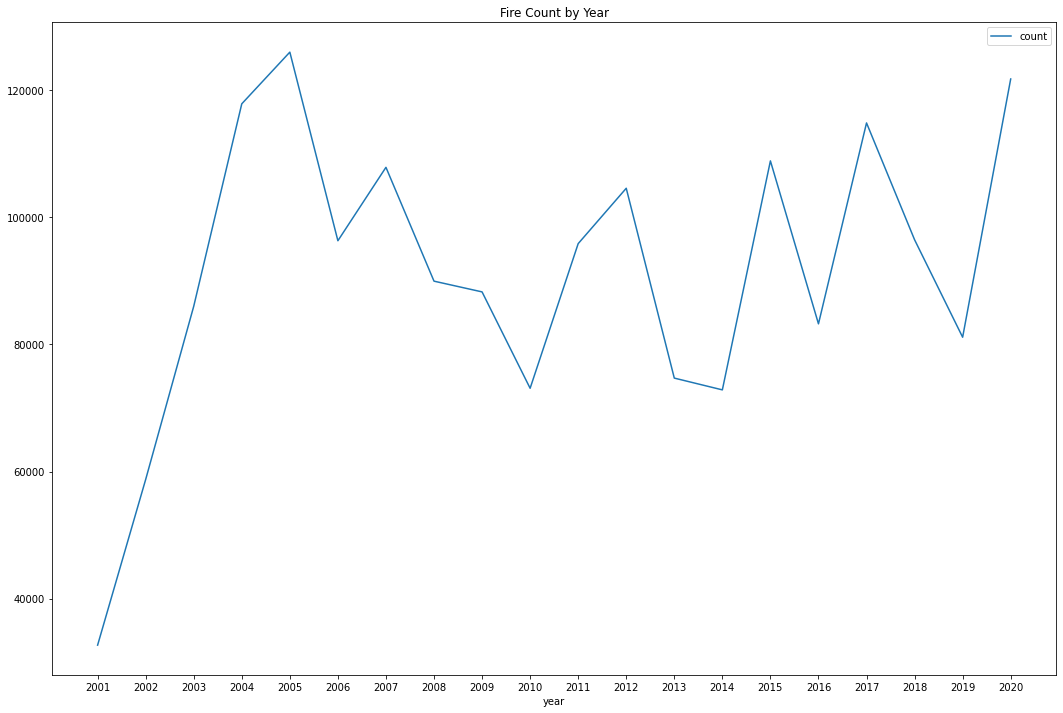

In [20]:
# Visualization of fire frequency by year
# As we don't have data for certain months in Year 2000 and 2021
# We exclude the data for fires occurred in Year 2000 and 2021

pdDF1 = fireByYear\
  .where(~col("year").isin([2000, 2021]))\
  .toPandas()
pdDF1.plot(kind = 'line',
           x = 'year',
           xticks = list(range(2001, 2021, 1)),
           y = 'count',
           title = 'Fire Count by Year',
           figsize = (18, 12))

### **Findings**
*   We see that fire frequency fluctuated over the years
*   We see a peak in fire frequency in year 2020





### **Fire Frequency by Month for Each Year Across the US**

In [ ]:
# Get fire count by month for each year
fireByMonthYear = fireData\
    .groupBy("month")\
    .pivot("year")\
    .count()\
    .orderBy("month")

fireByMonthYear.show()

+-----+----+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+
|month|2000|2001| 2002| 2003| 2004| 2005| 2006| 2007| 2008| 2009| 2010| 2011| 2012| 2013| 2014| 2015| 2016| 2017| 2018| 2019| 2020| 2021|
+-----+----+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+
|    1|null| 988|  918| 3585| 2937| 2984| 4362| 2006| 2945| 4478| 2079| 3066| 5438| 3301| 3055| 3616| 1849| 4328| 4128| 2121| 2982| 3329|
|    2|null|1416| 1978| 2299| 3260| 3257| 5225| 6678| 5485| 6786| 2543| 6333| 3735| 3711| 3725| 4756| 7230| 8239| 3148| 1978| 4168| 3659|
|    3|null|2026| 1519| 6415|11568| 9545|10721|10960|10117|10006|10577|10651|10838| 9616|10258| 9568|11189|11554|12442| 9497| 8082|13522|
|    4|null|3494| 2784|10762| 9082|11483|10525| 8096|11301|13761|12474|14593| 5926| 5736|10624| 7336|12021| 9133|11062| 8684| 7874|12522|
|    5|null|2107| 2973| 2512| 3319

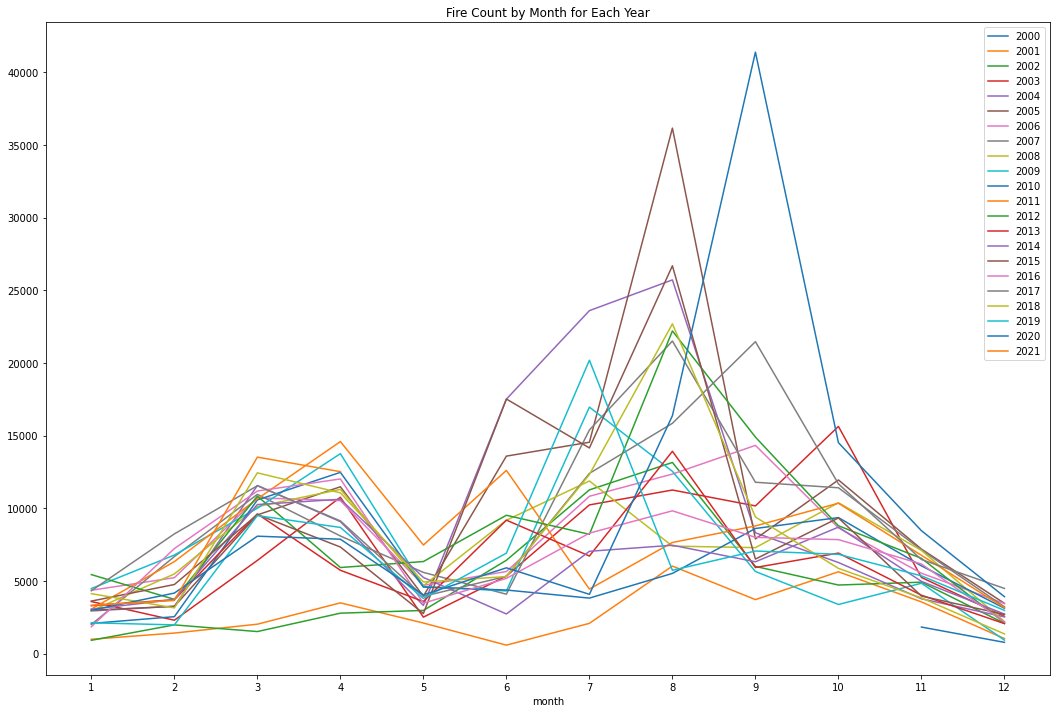

In [ ]:
# Visualization of fire count by month for each year
pdDF2 = fireByMonthYear.toPandas()
pdDF2.set_index('month', inplace = True)
pdDF2.plot(kind = 'line',
           xticks = list(range(1, 13, 1)),
           title = 'Fire Count by Month for Each Year',
           figsize = (18, 12))

#### **Findings**
*   We can see consistent patterns over the years:
*   Fire frequency increases from December to March, then decrease in sprint
*   Fire frequency increases in the summer; July, August, and September are the peak months
*   We see a peak of fire frequency in September 2020



### **Fire Frequency by Year for Each Month Across the US**

In [ ]:
# Get fire count by year for each month
fireByYearMonth = fireData\
    .groupBy("year")\
    .pivot("month")\
    .count()\
    .orderBy("year")

fireByYearMonth.show(22)

+----+----+----+-----+-----+----+-----+-----+-----+-----+-----+----+----+
|year|   1|   2|    3|    4|   5|    6|    7|    8|    9|   10|  11|  12|
+----+----+----+-----+-----+----+-----+-----+-----+-----+-----+----+----+
|2000|null|null| null| null|null| null| null| null| null| null|1828| 776|
|2001| 988|1416| 2026| 3494|2107|  584| 2084| 6025| 3717| 5633|3558|1036|
|2002| 918|1978| 1519| 2784|2973| 6426|11268|13154| 6001| 4721|4917|2086|
|2003|3585|2299| 6415|10762|2512| 5339|10233|11259|10165|15634|5243|2563|
|2004|2937|3260|11568| 9082|3319|17513|23602|25718| 8316| 6270|3774|2528|
|2005|2984|3257| 9545|11483|3955|13591|14547|36161| 7893|11952|7194|3462|
|2006|4362|5225|10721|10525|4701| 5650|10830|12356|14330| 8655|5531|3447|
|2007|2006|6678|10960| 8096|5590| 4090|15388|21511|11793|11413|7143|3222|
|2008|2945|5485|10117|11301|4673| 9181|11880| 7400| 7293|10384|7101|2209|
|2009|4478|6786|10006|13761|4617| 4315|16964|12544| 5652| 3382|4844| 930|
|2010|2079|2543|10577|12474|4578| 4377

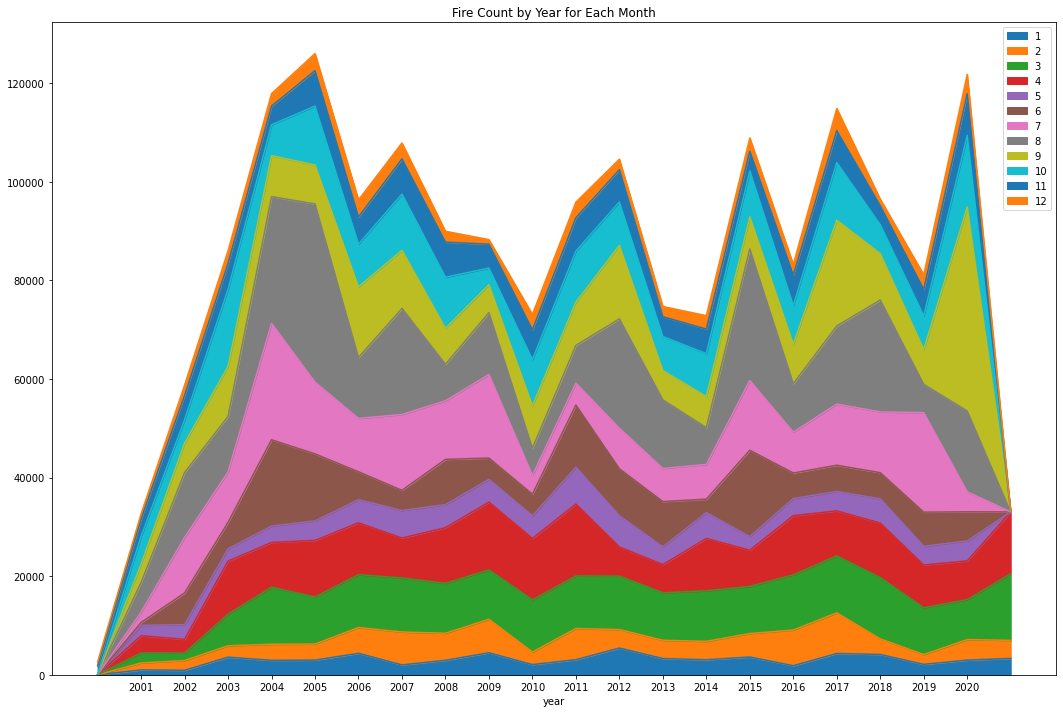

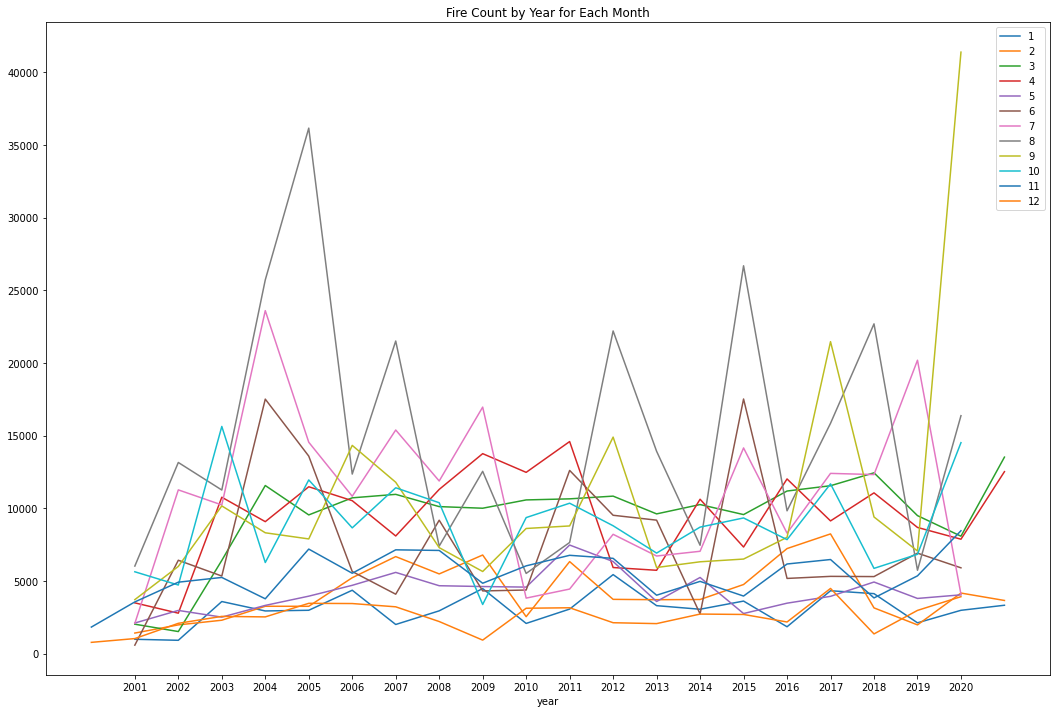

In [ ]:
# Visualization of fire count by year for each month
pdDF3 = fireByYearMonth.toPandas()
pdDF3.set_index('year', inplace = True)
pdDF3.head()
pdDF3.plot.area(xticks = list(range(2001, 2021, 1)),
                title = 'Fire Count by Year for Each Month',
                figsize = (18, 12))

pdDF3.plot(kind = 'line',
           xticks = list(range(2001, 2021, 1)),
           title = 'Fire Count by Year for Each Month',
           figsize = (18, 12))


### Findings: 
*   We see high fluctuations in fire frequencies in summer months: July to September
*   We see relatively lower fluctuations in fire frequencies in winter months: November to February
*   We see a peak in fire frequency in September 2020




## **Regional Fire Frequency Over the Years**

In [19]:
# Get fire count by region, year, month
# Define region with a granularity of 5 degrees
# For example, georegion 40,-125 means:
# a region with latitude from 40 to 45 and longitude from -125 to -120
fireByRegion = fireData\
    .where(~col("year").isin([2000, 2021]))\
    .withColumn("latRange", floor(col("latitude")/5) * 5)\
    .withColumn("lngRange", floor(col("longitude")/5) * 5)\
    .select(concat(col("latRange"), lit(","), col("lngRange")).alias("georegion"), "year", "month")\
    .groupBy("georegion", "year", "month")\
    .count()\
    .orderBy(desc("count"))

fireByRegion.show()

print(fireByRegion.select("georegion").distinct().count())

+---------+----+-----+-----+
|georegion|year|month|count|
+---------+----+-----+-----+
|  40,-125|2020|    9|14003|
|  45,-120|2015|    8|10546|
|  65,-150|2004|    8| 8479|
|  60,-160|2005|    8| 7724|
|  35,-125|2020|    9| 7534|
|  65,-145|2005|    8| 7016|
|  45,-115|2007|    8| 6861|
|  35,-120|2020|    9| 6853|
|  35,-125|2020|    8| 6832|
|  65,-150|2004|    7| 6820|
|  65,-145|2019|    7| 6511|
|  65,-150|2004|    6| 6448|
|  65,-150|2005|    8| 6071|
|  40,-125|2018|    8| 6031|
|  40,-125|2017|    8| 5845|
|  35,-100|2009|    4| 5727|
|  40,-120|2012|    8| 5468|
|  60,-145|2004|    8| 5376|
|  35,-100|2016|    4| 5334|
|  45,-115|2017|    9| 5308|
+---------+----+-----+-----+
only showing top 20 rows

72


In [20]:
# Calculate average yearly fire count for each region and show the top 10
fireMostRegion = fireByRegion\
    .groupBy("georegion", "year")\
    .sum("count")\
    .withColumnRenamed("sum(count)", "count")\
    .groupBy("georegion")\
    .avg("count")\
    .orderBy(desc("avg(count)"))\
    .limit(10)

fireMostRegion.show()

# Get a list of 10 regions with highest average yearly fire counts
regionList = fireMostRegion\
  .select("georegion")\
  .collect()

regionArray = [row.georegion for row in regionList]
regionArray

+---------+----------+
|georegion|avg(count)|
+---------+----------+
|   30,-85|    7580.7|
|   30,-95|    6306.4|
|  35,-100|   6142.25|
|   30,-90|    5899.2|
|  40,-125|    5697.8|
|  45,-120|    3831.5|
|  30,-100|    3403.2|
|  35,-125|    3270.3|
|   35,-95|   3244.95|
|   25,-85|   3136.75|
+---------+----------+



['30,-85',
 '30,-95',
 '35,-100',
 '30,-90',
 '40,-125',
 '45,-120',
 '30,-100',
 '35,-125',
 '35,-95',
 '25,-85']

In [21]:
# Extract fire data for the 10 regions with the highest average yearly fire counts
fireByRegionTop10 = fireByRegion\
    .where(col("georegion").isin(regionArray))

fireByRegionTop10.show()

+---------+----+-----+-----+
|georegion|year|month|count|
+---------+----+-----+-----+
|  40,-125|2020|    9|14003|
|  45,-120|2015|    8|10546|
|  35,-125|2020|    9| 7534|
|  35,-125|2020|    8| 6832|
|  40,-125|2018|    8| 6031|
|  40,-125|2017|    8| 5845|
|  35,-100|2009|    4| 5727|
|  35,-100|2016|    4| 5334|
|  40,-125|2012|    8| 4806|
|  35,-100|2005|    4| 4603|
|  40,-125|2017|    9| 4592|
|  35,-100|2008|    4| 4543|
|  35,-100|2011|    4| 4466|
|  40,-125|2008|    7| 4232|
|  35,-100|2003|    4| 4190|
|  35,-100|2014|    4| 4106|
|  35,-100|2010|    4| 3862|
|  40,-125|2015|    8| 3719|
|  40,-125|2002|    7| 3596|
|  35,-100|2017|    4| 3595|
+---------+----+-----+-----+
only showing top 20 rows



In [22]:
# Get fire count by year for each of the 10 regions
regionalFireByYear = fireByRegionTop10\
    .groupBy("year")\
    .pivot("georegion")\
    .sum("count")\
    .where(~col("year").isin([2000, 2021]))\
    .orderBy("year")

regionalFireByYear.show()

+----+------+-------+------+------+------+-------+-------+------+-------+-------+
|year|25,-85|30,-100|30,-85|30,-90|30,-95|35,-100|35,-125|35,-95|40,-125|45,-120|
+----+------+-------+------+------+------+-------+-------+------+-------+-------+
|2001|  1701|   1032|  3354|  3438|  3814|   1555|   1263|  1075|   1332|   1325|
|2002|  1456|   1610|  3244|  2879|  5020|   1565|   1807|  1535|   8337|   2035|
|2003|  2680|   2978|  4769|  5385|  8334|   8184|   2231|  3338|   3376|   3692|
|2004|  3506|   2961|  6157|  5189|  5722|   5740|   2157|  3551|   2414|   2387|
|2005|  3714|   3725|  6330|  5694|  9319|   9380|   1488|  4403|   2160|   3756|
|2006|  4642|   4440|  8603|  8046|  7702|   5109|   1869|  3465|   4588|   6097|
|2007|  4005|   3487| 10550|  8200|  7390|   4656|   1960|  3529|   3930|   7725|
|2008|  3266|   3999|  7956|  7164|  7986|   8390|   6335|  3191|  10617|   2328|
|2009|  2896|   4372|  7147|  4502|  4682|   8680|   1840|  2805|   3022|   1955|
|2010|  3573|   

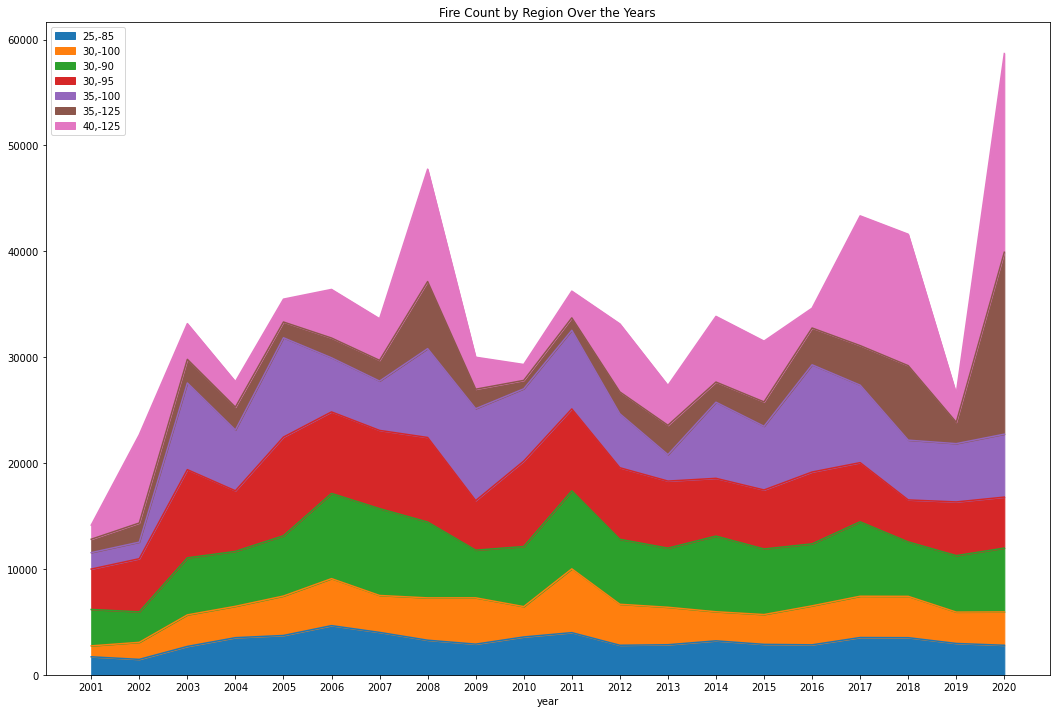

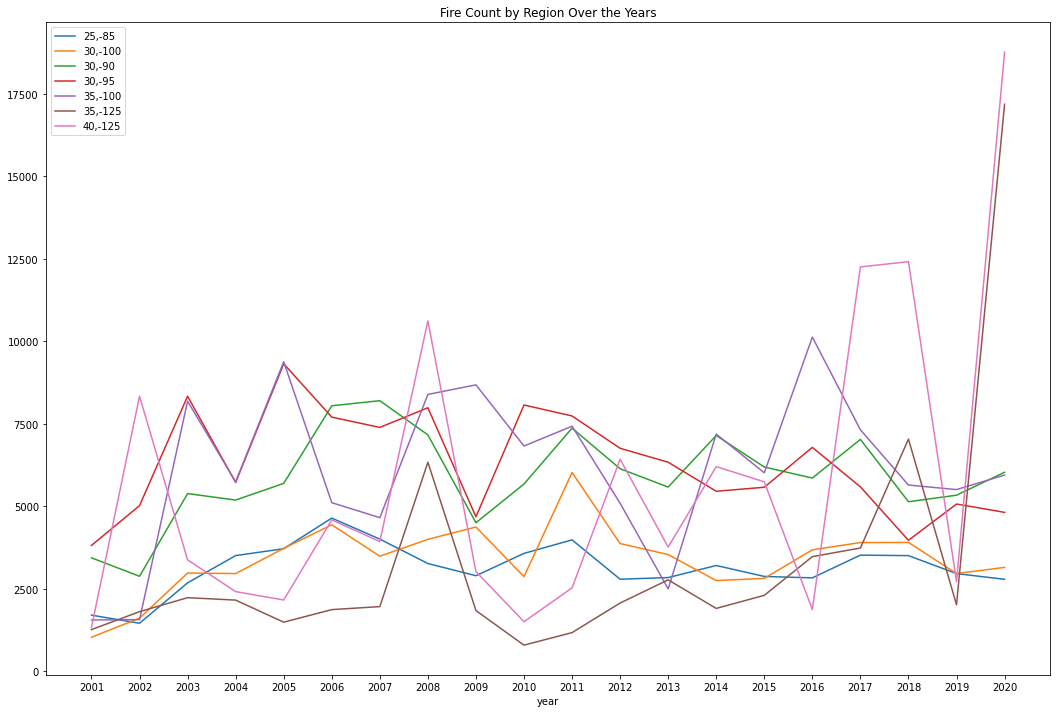

In [25]:
# Visualization of fire frequency by year for some of the regions
pdDF4 = regionalFireByYear\
  .drop("30,-85", "35,-95", "45,-120")\
  .toPandas()
pdDF4.set_index('year', inplace = True)
pdDF4.plot.area(title = 'Fire Count by Region Over the Years',
                xticks = list(range(2001, 2021, 1)),
                figsize = (18, 12))

pdDF4.plot(kind = 'line',
           title = 'Fire Count by Region Over the Years',
           xticks = list(range(2001, 2021, 1)),
           figsize = (18, 12))

#### **Findings**

*   The highest two fire count in a single month are those of region (40, -125) and (35, -125 ) in September 2020; These regions are in Northern California area
*   While we see fluctuations in fire frequencies over the years for each region, year 2020 was an abnormal year for region (35, -125) and (45,-120); for the two regions, the fire frequencies in 2020 were abnomally high





### **Year Over Year Increase in Fire Frequency for Each Region**

In [ ]:
# Use Window function to calcualte year over year increase in fire frequency by region
windowSpec = Window\
    .partitionBy("georegion")\
    .orderBy("year")

fireByRegionYoY = fireByRegionTop10\
    .groupBy("georegion", "year")\
    .sum("count")\
    .withColumnRenamed("sum(count)", "count")\
    .withColumn("pyCount", lag(col("count")).over(windowSpec))\
    .withColumn("yearlyChange", col("count") - col("pyCount"))\
    .withColumn("yearlyInc", col("yearlyChange")/col("pyCount"))\
    .orderBy(desc("yearlyChange"))

fireByRegionYoY.show()


+---------+----+-----+-------+------------+------------------+
|georegion|year|count|pyCount|yearlyChange|         yearlyInc|
+---------+----+-----+-------+------------+------------------+
|  40,-125|2020|18763|   2716|       16047| 5.908321060382916|
|  35,-125|2020|17184|   2016|       15168| 7.523809523809524|
|  40,-125|2017|12254|   1870|       10384| 5.552941176470588|
|  45,-120|2015|12636|   3557|        9079| 2.552431824571268|
|  40,-125|2002| 8337|   1332|        7005| 5.259009009009009|
|  40,-125|2008|10617|   3930|        6687| 1.701526717557252|
|  35,-100|2003| 8184|   1565|        6619| 4.229392971246006|
|   30,-85|2011|12669|   7603|        5066|0.6663159279231882|
|  35,-100|2014| 7188|   2497|        4691|1.8786543852623148|
|  35,-125|2008| 6335|   1960|        4375| 2.232142857142857|
|  45,-120|2017| 6872|   2506|        4366| 1.742218675179569|
|  35,-100|2016|10128|   6014|        4114|0.6840705021616229|
|  40,-125|2012| 6426|   2527|        3899|1.5429362880

## **Fire Intensity Change Analysis**

### **Review the Data Set**

In [ ]:
# Revisit fireData
fireData.show()

+--------+---------+----------+----+-----+---+----+----------+----+----+
|latitude|longitude|brightness|year|month|day|hour|confidence| frp|type|
+--------+---------+----------+----+-----+---+----+----------+----+----+
| 38.5451| -78.3107|     309.9|2000|   11|  1|   2|        79|58.8|   0|
| 38.5563| -78.3084|     309.4|2000|   11|  1|   2|        70|54.5|   0|
| 31.3393| -89.9124|     304.9|2000|   11|  1|   4|        62| 8.5|   0|
| 31.8611| -95.2398|     308.3|2000|   11|  1|   4|        74|13.1|   0|
| 31.8636|  -95.226|     308.6|2000|   11|  1|   4|        75|13.4|   0|
| 32.6448| -94.6467|     303.3|2000|   11|  1|   4|        54| 7.4|   0|
| 36.6376| -83.9651|     307.6|2000|   11|  1|   4|        72|39.6|   0|
| 36.6431| -83.9605|     309.4|2000|   11|  1|   4|        77|44.2|   0|
| 36.5423| -83.8422|     306.7|2000|   11|  1|   4|        69|40.9|   0|
| 38.4464|-120.3885|     302.9|2000|   11|  1|   6|        52|11.3|   0|
|  43.489|-123.6513|     302.9|2000|   11|  1|   6|

### **Fire Intensity by Year Across the US**

#### **Fire Intensity Measured by Fire Radiative Power**


> frp: Fire Radiative Power (MW - megawatts); frp depicts the pixel-integrated fire radiative power in MW (megawatts).



In [ ]:
# Fire intensity meaured by frp by year
fireIntensityFRPByYear = fireData\
    .where(~col("year").isin([2000, 2021]))\
    .groupBy("year")\
    .mean("frp")\
    .orderBy("year")

fireIntensityFRPByYear.show(22)

+----+------------------+
|year|          avg(frp)|
+----+------------------+
|2001| 53.39999081670152|
|2002| 87.25918801600085|
|2003| 76.34039693520488|
|2004|  81.9358097160832|
|2005| 68.11265790643036|
|2006| 75.06167356980477|
|2007| 89.67610899990633|
|2008|59.846170347564126|
|2009| 75.28246468582518|
|2010| 49.60305169135657|
|2011| 73.78258271100214|
|2012| 93.73931333836933|
|2013| 81.74170046446937|
|2014|  58.9441905154071|
|2015| 79.36219847019777|
|2016| 70.69273993994031|
|2017| 81.43793241525756|
|2018|  93.4305961486636|
|2019|63.467828798186424|
|2020|121.45331702190515|
+----+------------------+



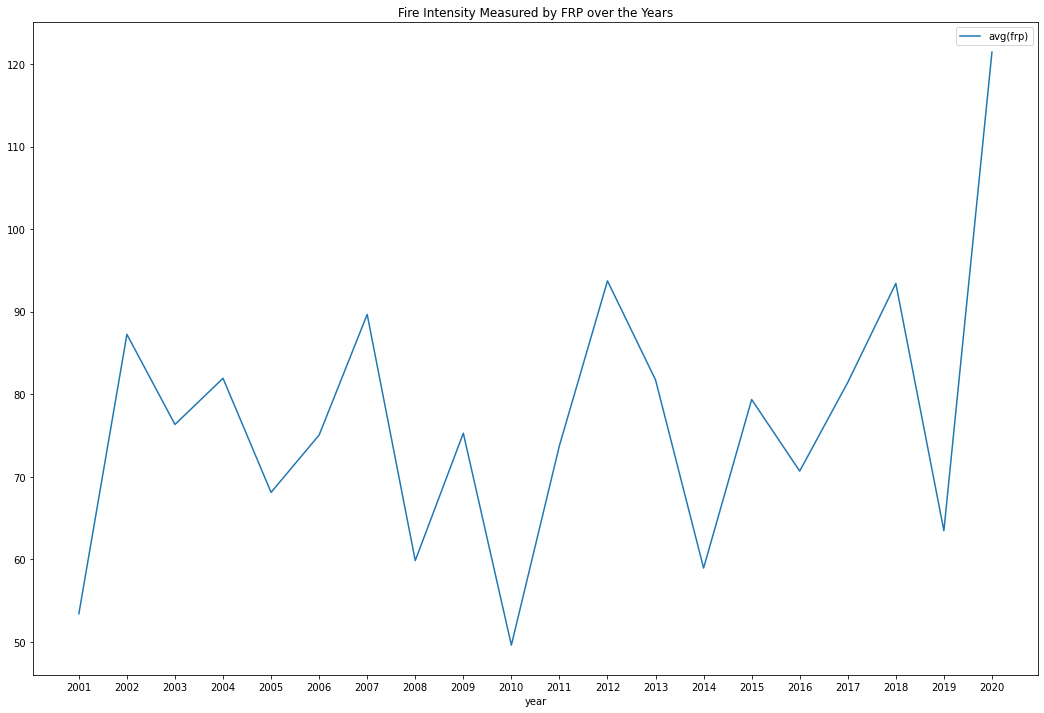

In [ ]:
# Visualization of fire intensity meaured by frp by year
pdDF5 = fireIntensityFRPByYear.toPandas()
pdDF5.set_index("year", inplace = True)
pdDF5.plot(kind = "line",
           xticks = list(range(2001, 2021, 1)),
           title = 'Fire Intensity Measured by FRP over the Years',
           figsize = (18, 12))

#### **Fire Intensity Measured by Brightness**


> brightness: Channel 21/22 brightness temperature of the fire pixel measured in Kelvin.



In [ ]:
# Fire intensity meaured by brightness by year
fireIntensityBRTByYear = fireData\
    .where(~col("year").isin([2000, 2021]))\
    .groupBy("year")\
    .mean("brightness")\
    .orderBy("year")

fireIntensityBRTByYear.show(22)

+----+------------------+
|year|   avg(brightness)|
+----+------------------+
|2001|324.12692849271554|
|2002|330.60576729934223|
|2003|328.61154065272314|
|2004|330.83224274093067|
|2005| 328.4692868025144|
|2006| 328.1185056003673|
|2007| 330.3273954954149|
|2008| 325.8691193633382|
|2009| 329.1984888818436|
|2010|324.39709193374586|
|2011| 329.3628509741779|
|2012|330.98254280879485|
|2013| 328.7412038710252|
|2014| 325.5336311852322|
|2015| 330.0683920553165|
|2016| 327.5341573573611|
|2017|329.13253886732684|
|2018|330.92701220902387|
|2019| 327.5175626047517|
|2020| 334.4796701041131|
+----+------------------+



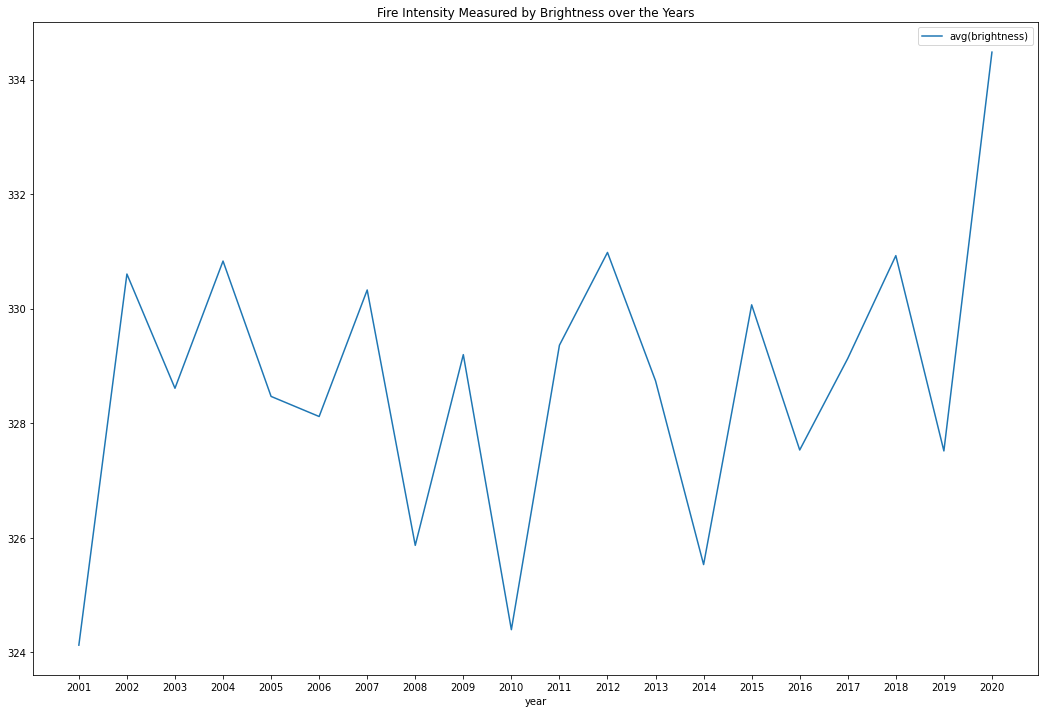

In [ ]:
# Visualization of fire intensity measured by brightness by year
pdDF6 = fireIntensityBRTByYear.toPandas()
pdDF6.set_index("year", inplace = True)
pdDF6.plot(kind = "line",
           xticks = list(range(2001, 2021, 1)),
           title = 'Fire Intensity Measured by Brightness over the Years',
           figsize = (18, 12))

### **Findings**


*  We used two attribute fields as the measurement of intensity; they produced the same insights
*  We see that the average fire intensity fluctuated over the years
*  We see that the peaks over the years stayed around 90 for frp and 330 for brightness;
*  We see that, in Year 2020, the average fire intensity abnormally increased to a record high




### **Fire Intensity by Year for Each Month Accross the US**

#### **Fire Intensity Measured by Brightness**

In [ ]:
# Get fire intensity meaured by frp by year for each month
fireIntensityBRTByYearMonth = fireData\
    .where(~col("year").isin([2000, 2021]))\
    .groupBy("year")\
    .pivot("month")\
    .avg("brightness")\
    .orderBy("year")

fireIntensityBRTByYearMonth.show()

+----+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|year|                 1|                 2|                 3|                 4|                 5|                 6|                 7|                 8|                 9|                10|                11|                12|
+----+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|2001| 316.9510121457486| 316.9067796610165|315.73593287265544| 322.4046365197477|  330.383388704318| 330.2602739726028| 330.2630998080618| 335.2225394190865|325.85840731772896| 320.7213562932717|315.16517706576684|  313.086293436293|
|2002|314.09542483660107|314.81354903943355|317.228505595786

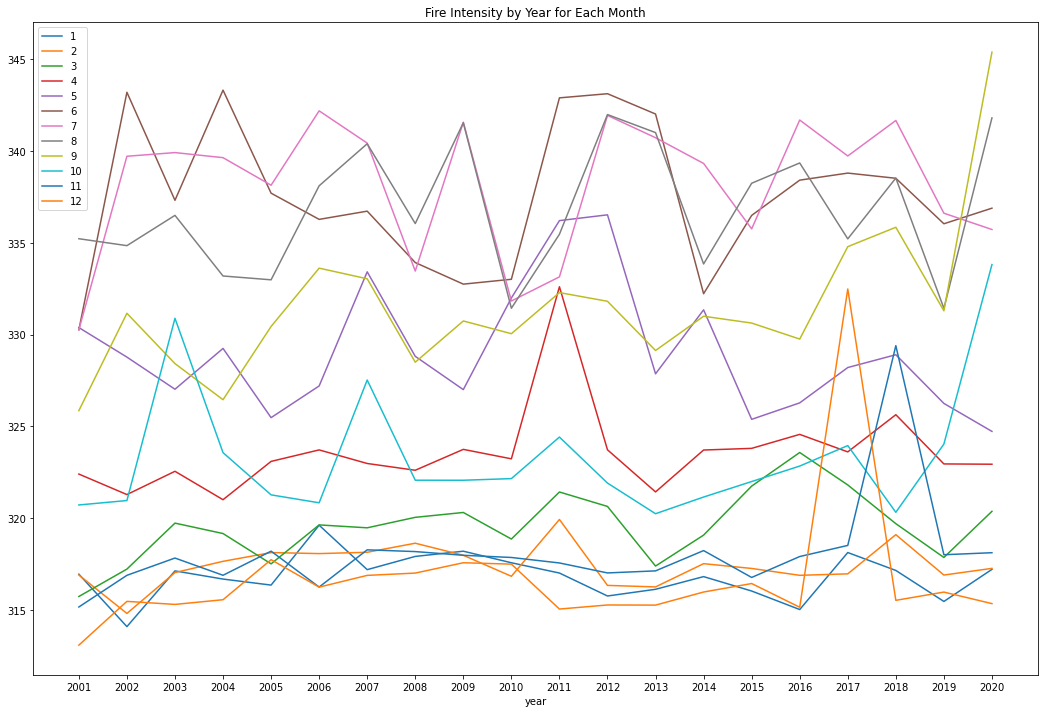

In [ ]:
# Visualization of fire intensity meaured by brightness by year for each month
pdDF7 = fireIntensityBRTByYearMonth.toPandas()
pdDF7.set_index('year', inplace = True)

pdDF7.plot(kind = 'line',
           xticks = list(range(2001, 2021, 1)),
           title = 'Fire Intensity by Year for Each Month',
           figsize = (18, 12))

### Findings
*   We see that fire intensity peaked in June through September
*   We see that fire intensity stayed relatively low and stable in winter months
*   We see that 2020 was a abnomal year in that the averge fire intensity for September and October increased to record highs.



### **Regional Fire Intensity Over the Years**

#### **Fire Intensity Measured by Brightness**

In [ ]:
# Get fire intensity measured by brightness by region, year, month
fireIntensityByRegion = fireData\
    .where(~col("year").isin([2000, 2021]))\
    .withColumn("latRange", floor(col("latitude")/5) * 5)\
    .withColumn("lngRange", floor(col("longitude")/5) * 5)\
    .select(concat(col("latRange"), lit(","), col("lngRange")).alias("georegion"), "year", "month", "brightness")

fireIntensityByRegion.show()

+---------+----+-----+----------+
|georegion|year|month|brightness|
+---------+----+-----+----------+
|   25,-85|2001|    1|     309.3|
|   25,-85|2001|    1|     343.9|
|   25,-85|2001|    1|     327.0|
|  35,-120|2001|    1|     303.0|
|   35,-80|2001|    1|     321.6|
|   35,-80|2001|    1|     311.6|
|   30,-85|2001|    1|     320.2|
|   30,-85|2001|    1|     306.9|
|   30,-85|2001|    1|     331.1|
|   30,-85|2001|    1|     341.8|
|   30,-85|2001|    1|     302.1|
|   30,-85|2001|    1|     304.4|
|   30,-85|2001|    1|     324.8|
|   30,-85|2001|    1|     303.6|
|   30,-85|2001|    1|     302.6|
|   30,-85|2001|    1|     313.4|
|   30,-90|2001|    1|     307.8|
|   30,-90|2001|    1|     313.2|
|   30,-90|2001|    1|     307.4|
|   30,-90|2001|    1|     340.9|
+---------+----+-----+----------+
only showing top 20 rows



In [ ]:
# Calculate average fire intensity by region
fireIntensityAvgByRegion = fireIntensityByRegion\
    .groupBy("georegion")\
    .avg("brightness")\
    .orderBy(desc("avg(brightness)"))

fireIntensityAvgByRegion.show()

print(fireIntensityAvgByRegion.select("georegion").distinct().count())

+---------+------------------+
|georegion|   avg(brightness)|
+---------+------------------+
|  50,-165| 387.6230769230769|
|  30,-125| 353.6729907773385|
|  30,-120|351.12276770557355|
|  40,-110| 347.5236673106049|
|  40,-115|343.81590328562993|
|  55,-155| 343.3362126245846|
|  35,-115| 342.4442937438898|
|  40,-120|342.04932317947396|
|  35,-110|340.28794135750735|
|  65,-145|339.53158322186187|
|  60,-150|339.51346620885914|
|  45,-110|  339.437575421318|
|  60,-145|338.86945877592314|
|  30,-110| 338.8623752604456|
|  30,-115|338.77139338494044|
|  65,-150|338.75308385913735|
|  20,-160| 338.1024647887324|
|  60,-155| 337.5375884665781|
|  35,-120| 337.4725608560122|
|  65,-155| 336.5045954085024|
+---------+------------------+
only showing top 20 rows

72


In [ ]:
# Get a list of regions with highest average fire intensity
regionList2 = fireIntensityAvgByRegion\
  .limit(7)\
  .select("georegion")\
  .collect()

regionArray2 = [row.georegion for row in regionList2]
regionArray2

['50,-165', '30,-125', '30,-120', '40,-110', '40,-115', '55,-155', '35,-115']

In [ ]:
# Extract fire data for the regions with the highest average fire intensity
fireIntensityByRegionTop5 = fireIntensityByRegion\
    .where(col("georegion").isin(regionArray2))\
    .groupBy("georegion", "year")\
    .avg("brightness")

fireIntensityByRegionTop5.show()

+---------+----+------------------+
|georegion|year|   avg(brightness)|
+---------+----+------------------+
|  35,-115|2003|   344.65821299639|
|  40,-115|2001|  332.694022988506|
|  40,-115|2011| 340.6305681818181|
|  30,-120|2003| 356.3495660798408|
|  55,-155|2007|345.87071823204406|
|  35,-115|2002|341.02185238784386|
|  30,-120|2004|340.92568922305765|
|  30,-120|2011| 336.0863049095607|
|  30,-120|2005| 337.9960072595281|
|  55,-155|2005| 332.6519999999999|
|  35,-115|2009|339.60130168453276|
|  40,-115|2005| 342.8925756186987|
|  30,-125|2010|           375.225|
|  35,-115|2001| 327.1176229508197|
|  35,-115|2004| 345.8801675977657|
|  35,-115|2005| 342.0290201005021|
|  35,-115|2010| 344.1855585831062|
|  40,-115|2009|344.07037773359826|
|  30,-120|2009|352.02079482439933|
|  40,-115|2008| 337.0276264591438|
+---------+----+------------------+
only showing top 20 rows



In [ ]:
# Get fire intensity by year for each of the regions
regionalFireIntensityByYear = fireIntensityByRegionTop5\
    .groupBy("year")\
    .pivot("georegion")\
    .avg("avg(brightness)")\
    .withColumnRenamed("avg(avg(brightness))", "avg(brightness)")\
    .orderBy("year")

regionalFireIntensityByYear.show()

+----+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+
|year|           30,-120|           30,-125|           35,-115|           40,-110|           40,-115|          50,-165|           55,-155|
+----+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+
|2001| 331.7942857142856|316.96000000000004| 327.1176229508197| 327.9236363636361|  332.694022988506|             null|             313.2|
|2002| 346.1689200329764|           335.875|341.02185238784386|343.76379870129836|342.86175908221793|             null|              null|
|2003| 356.3495660798408| 328.7428571428572|   344.65821299639|336.85588673621436|339.19713168187695|             null|331.31632653061223|
|2004|340.92568922305765|362.56964285714304| 345.8801675977657|332.42435530085976| 332.5552941176472|             null|              null|
|2005| 337.9960072595281| 3

In [ ]:
# Drop columns with null values
regionalFireIntensityByYear = regionalFireIntensityByYear\
    .drop("50,-165", "55,-155", "30,-125", "30,-120")

regionalFireIntensityByYear.show()

+----+------------------+------------------+------------------+
|year|           35,-115|           40,-110|           40,-115|
+----+------------------+------------------+------------------+
|2001| 327.1176229508197| 327.9236363636361|  332.694022988506|
|2002|341.02185238784386|343.76379870129836|342.86175908221793|
|2003|   344.65821299639|336.85588673621436|339.19713168187695|
|2004| 345.8801675977657|332.42435530085976| 332.5552941176472|
|2005| 342.0290201005021|332.79259259259254| 342.8925756186987|
|2006|342.18252100840294|  347.408299595142|340.85729426433943|
|2007| 339.2172201722013| 338.9752902155887|345.81794181034553|
|2008|331.54571428571444|344.57822651448646| 337.0276264591438|
|2009|339.60130168453276|327.39615384615394|344.07037773359826|
|2010| 344.1855585831062| 336.7215189873419|334.05820170109337|
|2011| 331.6005988023953| 338.8617302052784| 340.6305681818181|
|2012|347.11478382147806| 350.2429219975231| 348.4615306639632|
|2013|332.45995260663517| 338.7883089770

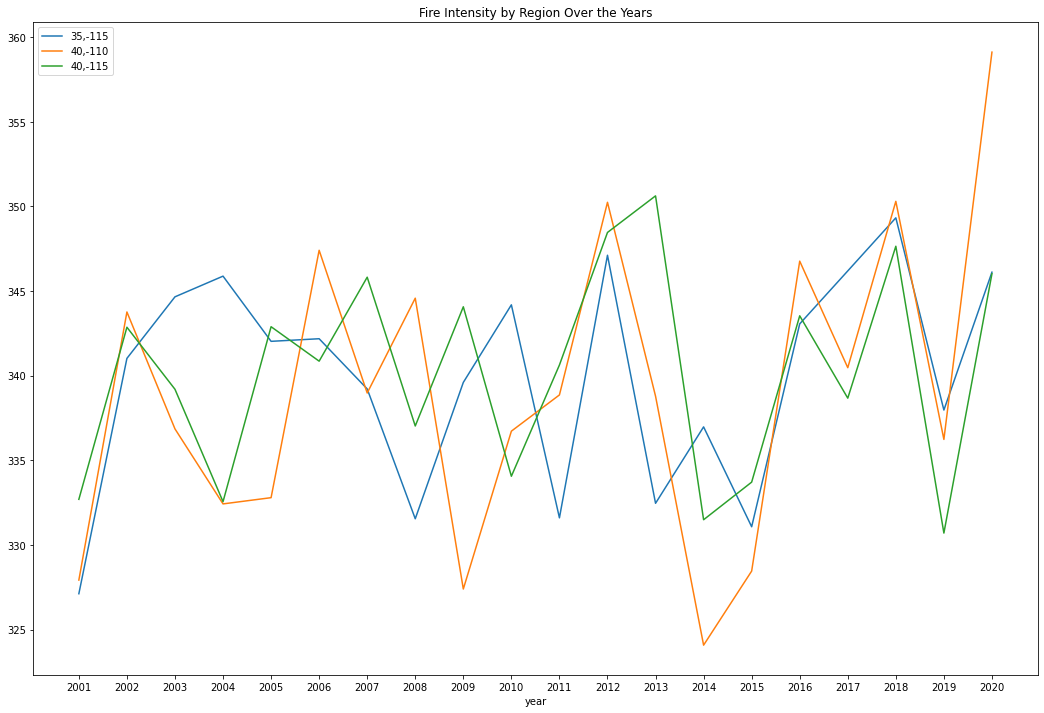

In [ ]:
# Visualization of fire intensity by region over the years
pdDF8 = regionalFireIntensityByYear.toPandas()
pdDF8.set_index('year', inplace = True)

pdDF8.plot(kind = "line",
           xticks = list(range(2001, 2021, 1)),
           title = 'Fire Intensity by Region Over the Years',
           figsize = (18, 12))


#### **Findings**

*   While we see flucations in fire flucations over the years for each region,
year 2020 was an abnomal year for region (40,-110); for this, the average fire intensity in 2020 was abnomally high

### **Year Over Year Increase in Fire Intensity for Each Region**

In [ ]:
# Use Window function to calcualte year over year increase in fire intensity by region
windowSpec = Window\
    .partitionBy("georegion")\
    .orderBy("year")

fireIntensityByRegionYoY = fireIntensityByRegionTop5\
    .groupBy("georegion", "year")\
    .avg("avg(brightness)")\
    .withColumnRenamed("avg(avg(brightness))", "avg(brightness)")\
    .withColumn("pyavg(brightness)", lag(col("avg(brightness)")).over(windowSpec))\
    .withColumn("yearlyChange", col("avg(brightness)") - col("pyavg(brightness)"))

fireIntensityByRegionYoY = fireIntensityByRegionYoY\
    .withColumn("yearlyInc", col("yearlyChange")/col("pyavg(brightness)"))\
    .orderBy(desc("yearlyChange"))

fireIntensityByRegionYoY.show()

+---------+----+------------------+------------------+------------------+--------------------+
|georegion|year|   avg(brightness)| pyavg(brightness)|      yearlyChange|           yearlyInc|
+---------+----+------------------+------------------+------------------+--------------------+
|  55,-155|2015|363.52413793103443|             303.4|60.124137931034454| 0.19816789034619137|
|  30,-125|2007| 353.9297297297298|             313.8|40.129729729729775| 0.12788314126746264|
|  55,-155|2009|363.11666666666673|324.43333333333334|38.683333333333394| 0.11923353539504795|
|  30,-125|2009| 361.7506912442395| 323.6714285714285|38.079262672810955| 0.11764789632770302|
|  30,-125|2004|362.56964285714304| 328.7428571428572| 33.82678571428585| 0.10289740135581475|
|  50,-165|2020| 411.0142857142858| 379.0052631578947| 32.00902255639107| 0.08445535106739671|
|  40,-110|2020|359.11502267573684|336.23417721518985|22.880845460546993|  0.0680503262638386|
|  30,-125|2016| 349.4383177570094| 326.8846153846